In [2]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import math


%matplotlib inline

In [3]:
def minor(arr,i,j):
    # ith row, jth column removed
    return arr[np.array(list(range(i))+list(range(i+1,arr.shape[0])))[:,np.newaxis],
               np.array(list(range(j))+list(range(j+1,arr.shape[1])))]

# Задание 2.
Случайный вектор $(\xi_1, \xi_2, \xi_3, \xi_4, \xi_5, \eta)$ имеет компоненты, распределённые по следующему закону

$\xi_i \sim U[-1, 1]$, $\eta \sim N(2+3x_1-2x_2+x_3+x_4-x_5, 1.5^2)$, где $x_i$ это значения, которые принимает случайная величина $\xi_i$. Сгенерировать выборку объёма n=50

## 1. Генерируем выборку

In [4]:
params = {
    'n_samples': 50,
    'n_features': 6,
    'sigma': 1.5
}

### $\xi_i \sim U[-1, 1]$

In [5]:
np.random.seed(42)
ksi = 2*np.random.rand(params['n_samples'], params['n_features']-1)-1

### $\eta \sim N(2+3x_1-2x_2+x_3+x_4-x_5, 1.5^2)$

In [6]:
L = np.array([2, 3, -2, 1, 1, -1], dtype=np.float32).reshape(-1, 1)
observations = np.hstack((np.ones_like(ksi[:, 0]).reshape(-1, 1), ksi))
y_true = observations@L

eta = y_true + np.random.normal(loc=0, scale=params['sigma'], size=params['n_samples']).reshape(-1, 1)

In [7]:
def make_correlation_matrix(observations):
    means = observations.mean(axis=0)  # output shape (6, )
    obs_centered = observations-means.reshape(1, -1)
    covariance = obs_centered.T@obs_centered
    sigmas = np.diag(covariance)**0.5
    denominator = sigmas.reshape(-1, 1)*sigmas.reshape(1, -1)
    return covariance/denominator

covariance_matrix = make_correlation_matrix(observations[:, 1:])

In [8]:
def pretty_print(x):
    arr_string = np.array2string(x, precision=5)
    print(arr_string)
    
print('Ковариационная матрица: \n')
pretty_print(covariance_matrix)

Ковариационная матрица: 

[[ 1.      -0.1421  -0.33102 -0.01341 -0.03378]
 [-0.1421   1.       0.21995  0.02763 -0.22868]
 [-0.33102  0.21995  1.      -0.02046  0.00605]
 [-0.01341  0.02763 -0.02046  1.       0.19713]
 [-0.03378 -0.22868  0.00605  0.19713  1.     ]]


In [9]:
from IPython.display import display, Math, Latex

def pairwise_corr_matrix_ci(corr_matrix, n, beta=0.95):
    u_b = stats.norm.ppf(0.5*(1+beta))
    z1 = np.arctanh(corr_matrix) - 0.5*corr_matrix/(n-1) - u_b/math.sqrt(n-3)
    z2 = np.arctanh(corr_matrix) - 0.5*corr_matrix/(n-1) + u_b/math.sqrt(n-3)
    lower_bound = np.tanh(z1)
    upper_bound = np.tanh(z2)
       
    ci = np.dstack([lower_bound, upper_bound])
        
    for i, ci_1 in enumerate(ci):
        for j, ci_2 in enumerate(ci_1[i+1:]):
            print(f'r_{i}_{j+i+1}', ci_2)

    
pairwise_corr_matrix_ci(covariance_matrix, 50)

r_0_1 [-0.40323736  0.14327865]
r_0_2 [-0.55562513 -0.05464737]
r_0_3 [-0.29054688  0.26605808]
r_0_4 [-0.30890606  0.24721528]
r_1_2 [-0.06444484  0.46779663]
r_1_3 [-0.25292563  0.3033857 ]
r_1_4 [-0.4748832   0.05536689]
r_2_3 [-0.29692081  0.2595641 ]
r_2_4 [-0.27281158  0.28386542]
r_3_4 [-0.08792661  0.44914285]


/home/alexandr/anaconda3/envs/diploma/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in arctanh
  """
/home/alexandr/anaconda3/envs/diploma/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in arctanh
  """
/home/alexandr/anaconda3/envs/diploma/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in arctanh
  
/home/alexandr/anaconda3/envs/diploma/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in arctanh
  


## проверка гипотезы зависимости

$
H_0: r_{ij}=0 \\
H_1: r_{ij} \ne 0
$

In [10]:
def dependence_test(covariance, n):
    covariance_matrix = covariance - np.eye(covariance.shape[0])
    
    delta = covariance_matrix*math.sqrt(n-2)/np.sqrt(1-covariance_matrix**2)
    
    p_values = stats.t.sf(delta, n-2)
    
    pretty_print(p_values)
    
dependence_test(covariance_matrix, params['n_samples'])

[[0.5     0.83754 0.99056 0.53682 0.59207]
 [0.83754 0.5     0.06242 0.42447 0.94491]
 [0.99056 0.06242 0.5     0.55606 0.48336]
 [0.53682 0.42447 0.55606 0.5     0.085  ]
 [0.59207 0.94491 0.48336 0.085   0.5    ]]


Все коэффициенты, за исклбчением быть может $r_{4, 5}$ прошли тест

## очищенный коэффициент корреляции

In [11]:
def get_ro(Q):
    ro = np.zeros_like(Q)
    for i, row in enumerate(Q):
        for j, elem in enumerate(row):
            Q_ij = (-1)**(i+j)*np.linalg.det(minor(Q, i, j))
            Q_jj = (-1)**(j+j)*np.linalg.det(minor(Q, j, j))
            Q_ii = (-1)**(i+i)*np.linalg.det(minor(Q, i, i))
            ro[i, j] = (-1) * Q_ij / np.sqrt(Q_ii*Q_jj)
    return ro

ro = get_ro(covariance_matrix)
pretty_print(covariance_matrix)
pretty_print(ro)

[[ 1.      -0.1421  -0.33102 -0.01341 -0.03378]
 [-0.1421   1.       0.21995  0.02763 -0.22868]
 [-0.33102  0.21995  1.      -0.02046  0.00605]
 [-0.01341  0.02763 -0.02046  1.       0.19713]
 [-0.03378 -0.22868  0.00605  0.19713  1.     ]]
[[-1.      -0.08473 -0.30768 -0.00796 -0.0502 ]
 [-0.08473 -1.       0.19176  0.08243 -0.25034]
 [-0.30768  0.19176 -1.      -0.04106  0.04777]
 [-0.00796  0.08243 -0.04106 -1.       0.21046]
 [-0.0502  -0.25034  0.04777  0.21046 -1.     ]]


In [12]:
dependence_test(covariance_matrix, params['n_samples']+2-params['n_features'])

[[0.5     0.82691 0.98768 0.53524 0.58817]
 [0.82691 0.5     0.07095 0.42769 0.93683]
 [0.98768 0.07095 0.5     0.55367 0.48408]
 [0.53524 0.42769 0.55367 0.5     0.09457]
 [0.58817 0.93683 0.48408 0.09457 0.5    ]]


## Тест пирсона

В документации сказано, что стоит им пользоваться при n>500, так что он не очень здесь подходит

In [13]:
observation_tr = observations.T
for i in range(1, params['n_features']):
    for j in range(i+1, params['n_features']):
        a = observations[:, i]
        b = observations[:, j]
        print("{0}:{1} r = {2:.4}, p-value = {3:.4}".format(i, j, *stats.pearsonr(a, b)))

1:2 r = -0.1421, p-value = 0.3249
1:3 r = -0.331, p-value = 0.01887
1:4 r = -0.01341, p-value = 0.9264
1:5 r = -0.03378, p-value = 0.8159
2:3 r = 0.2199, p-value = 0.1248
2:4 r = 0.02763, p-value = 0.8489
2:5 r = -0.2287, p-value = 0.1102
3:4 r = -0.02046, p-value = 0.8879
3:5 r = 0.006053, p-value = 0.9667
4:5 r = 0.1971, p-value = 0.17


## 2. Уравнение линейной регрессии

### 2.1 Коэффициенты

In [14]:
F = observations.T@observations
F_inv = np.linalg.inv(F)
beta = F_inv@observations.T@eta

In [15]:
# или через псевдообратную матрицу
# y = Ax => x = pseudo_inverse(A)*y
beta_1 = np.linalg.pinv(observations)@eta

In [16]:
print('Коэффициенты линейной регрессии')
pretty_print(beta[:, 0])

Коэффициенты линейной регрессии
[ 2.0699   2.75517 -2.14092  1.00962  0.76835 -1.21049]


### 2.2 Значимость коэфициентов

In [17]:
y_estimated = observations@beta
errors = eta - y_estimated
rss = (errors.T@errors)[0, 0]
rss

129.49976494488024

In [18]:
def significance_test(beta, F_inv, rss, n):
    """
    beta is an array with shape [n_features, 1]
    F_inv is an array with shape [n_features, n_features]
    """
    p = F_inv.shape[0]
    diag = np.diag(F_inv).reshape(-1, 1)
    delta = beta * math.sqrt(n-p) / np.sqrt(diag*rss)
    degrees_of_freedom = n-p
    p_values = stats.t.sf(np.abs(delta), degrees_of_freedom)
    
#     print('delta:')
#     pretty_print(delta[:, 0])
#     print('')
    
#     print('p_values:')
#     pretty_print(p_values[:, 0])
    return p_values

p_values = significance_test(beta, F_inv, rss, params['n_samples'])

Можно принять, что при p-value меньше 0.05 альтернативная гипотеза принимается, а значит коэффициент значимый

In [19]:
for i, p in enumerate(p_values[:, 0]):
    print(f'p-value теста на значимость для beta_{i} = {beta[i, 0]} равен {p}')

p-value теста на значимость для beta_0 = 2.0699044106439626 равен 5.58565126992056e-11
p-value теста на значимость для beta_1 = 2.7551697250067524 равен 5.693268274621846e-08
p-value теста на значимость для beta_2 = -2.1409204420128543 равен 9.66581336696048e-06
p-value теста на значимость для beta_3 = 1.0096160496557551 равен 0.0126890270760508
p-value теста на значимость для beta_4 = 0.7683526281707027 равен 0.033993137643700606
p-value теста на значимость для beta_5 = -1.2104888881099156 равен 0.003984155738591228


## 3. Коэффициент детерминации

In [20]:
y_mean = eta.mean()
rss_0 = np.sum((eta-y_mean)**2)
r_2 = 1 - rss/rss_0

print('Коэффициент детерминации R^2 = {:.5f}'.format(r_2))

Коэффициент детерминации R^2 = 0.62638


### 3.2 Проверка на значимость

In [21]:
delta_r_2 = ((params['n_samples'] - params['n_features']) / (params['n_features'] - 1)) * (r_2 / (1 - r_2))
p_value_r_2 = stats.f.sf(delta_r_2, params['n_features']-1, params['n_samples'] - params['n_features'])
print('p-value для теста на значимость коэффициента детерминации = {}'.format(p_value_r_2))

p-value для теста на значимость коэффициента детерминации = 1.703381653768345e-08


Значит, можно принять гипотезу о том, что коэффициент значимый

## 4. Найти значение в точке (0, 0, 0, 0, 0)

In [22]:
x_0 = np.zeros((1, params['n_features']))
x_0[0] = 1
y_0 = x_0@beta
print('y_estimated(x_0) =', y_0[0, 0])

y_estimated(x_0) = 3.2516334833544023


### 95% Доверительный интервал

In [53]:
def confidence_interval(x_0, beta, F_inv, rss, params, quantile=0.95):
    alpha = (1-quantile)/2
    df = params['n_samples'] - params['n_features']
    
    quantiles = stats.t.ppf((alpha, 1-alpha), df)
    tmp = np.diag(x_0@(F_inv@x_0.T))
    multiplier = np.sqrt(rss*(1+tmp)) / math.sqrt(df)
    
    return x_0@beta + quantiles.reshape(-1, 1)*multiplier

pretty_print(confidence_interval(x_0, beta, F_inv, rss, params, quantile=0.9)[:, 0])

[-5.38769 -4.82873]


## Проверка предположения о независимости/случайности ошибок распределения

In [24]:
def count_g_elem(elem, arr):
    out = 0
    for i in arr:
        if i>elem:
            out += 1
    return out

def randomness_hyp(e):
    inversions = 0
    
    for i, elem in enumerate(e):
        inversions += count_g_elem(elem, e[i:])
    
    n = e.shape[0]
    delta = (inversions-n*(n-1)/4) / np.sqrt((n**3)/36)
    p_value = stats.norm.sf(delta)
    return p_value
    
print('p-значение для теста на случайность ошибки:', randomness_hyp(errors.reshape(-1)))

p-значение для теста на случайность ошибки: 0.284843051281288


Больше 0.05

## Предположение о нормальности распределения ошибок

##### 1. Тест [Shapiro-Wilk](http://webspace.ship.edu/pgmarr/Geo441/Readings/Shapiro%20and%20Wilk%201965%20-%20An%20Analysis%20of%20Variance%20Test%20for%20Normality.pdf)

In [25]:
print("W = {0:.4}, p-value = {1:.4}".format(*stats.shapiro(eta)))

W = 0.9677, p-value = 0.1866


##### 2. Критерий Колмогорова

In [36]:
import math
import scipy
from tqdm import tqdm_notebook

def construct_f_hat(x):
    n = len(x) if isinstance(x, (list, tuple)) else x.shape[0]
    delta_f = 1.0/(n)
    
    
def get_delta(x):
    """
    Theta1 and theta2 are parameters from raw data
    
    """
    n = len(x) if isinstance(x, (list, tuple)) else x.shape[0]
    theta1_hat = np.mean(x)
    theta2_hat = np.sqrt((1/(n-1))*np.sum((x-theta1_hat)**2))
    
    delta_f = 1.0/(n)
    f2 = stats.norm.cdf(x, loc=theta1_hat, scale=theta2_hat)
    f1 = np.array([delta_f*(i+1) for i in range(n)])
    return  math.sqrt(n)*np.max(np.abs(f2-f1))

In [34]:
theta1 = np.mean(eta)
theta2 = math.sqrt((1/(params['n_samples']-1))*np.sum((eta-theta1)**2))

deltas = []
N = 1e6
samples = stats.norm.rvs(
    loc=theta1, scale=theta2, size=params['n_samples']*N)

for i in tqdm_notebook(range(N)):
    batch = samples[params['n_samples']*i:params['n_samples']*(i+1)]
    delta = get_delta(batch, theta1, theta2)
    deltas.append(delta)

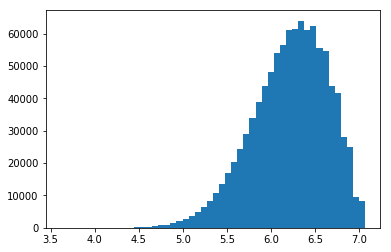

In [35]:
plt.hist(deltas, bins=50)
plt.show()

In [38]:
delta = get_delta(eta)
pos = np.digitize(delta, np.sort(deltas))

In [44]:
print('p-value:', pos/N)

p-value: 0.954105


In [42]:
delta

6.855967088100751

## Кросс-проверка регрессии

In [49]:
from sklearn.model_selection import LeaveOneOut

residuals = []
residuals0 = []

loo = LeaveOneOut()

for train_index, test_index in loo.split(observations.T):
    X_train, X_test = observations[train_index], observations[test_index]
    y_train, y_test = eta[train_index], eta[test_index]
    beta = np.linalg.pinv(X_train)@y_train
    rss = (y_test - X_test@beta)**2
    residuals.append(rss)

rss0 = np.sum((eta-eta.mean())**2)
rss_star = sum(residuals)
r_start_sq = 1 - rss_star/rss0
print(np.squeeze(r_start_sq))

0.9403682895337638
